## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'torchsummary'

In [18]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [0]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [0]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [21]:
len(fmnist_dataset_test)

10000

In [22]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [0]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 300),
            nn.BatchNorm1d(300, eps=1e-5),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.Dropout(0.5),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [41]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
              ReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 300]         150,300
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
              ReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
Total params: 573,910
Trainable params: 573,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.19
Estimated Total Size (MB): 2.21
----------------------------------------------------------------


Your experiments come here:

In [0]:
from torch.optim import SGD, Adam

In [0]:
def my_acc_score(y_true, y_pred):
    y_pred = y_pred.max(1)[1].data
    return np.mean(np.array(y_true.cpu() == y_pred.cpu()))

In [0]:
import time

def train(model, train_loader, test_loader, n_epoch):
    opt = SGD(model.parameters(), lr=0.1, momentum=0.9)
    loss_func = nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []
    test_acc_history = []

    for i in range(n_epoch):
        train_loss = []
        test_loss = []
        test_acc = []
        start_time = time.time()

        model.train()
        for x_batch, y_batch in train_loader:
            opt.zero_grad()

            X_batch = x_batch.to(device)
            Y_batch = y_batch.to(device)

            # Forward
            predictions = model(X_batch)
            loss = loss_func(predictions, Y_batch)

            # Backward
            loss.backward()

            # Update weights
            opt.step()

            train_loss.append(loss.item())

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                X_batch = x_batch.to(device)
                Y_batch = y_batch.to(device)

                # Forward
                predictions = model(X_batch)
                loss = loss_func(predictions, Y_batch)

                test_loss.append(loss.item())
                test_acc.append(my_acc_score(Y_batch, predictions))


        print("Epoch:", i)
        print("\tTime:                  {:.2f}s".format(time.time() - start_time))
        print("\tAccuracy: test:        {:.2f} %".format(np.mean(test_acc) * 100))

        train_loss_history.append(np.mean(train_loss))
        test_loss_history.append(np.mean(test_loss))
        test_acc_history.append(np.mean(test_acc))

    clear_output()
    return train_loss_history, test_loss_history, test_acc_history

In [0]:
model = TinyNeuralNetwork().to(device)
train_loss_history, test_loss_history, test_acc_history = train(model, 
                                                                train_loader, 
                                                                test_loader, 
                                                                n_epoch=40)

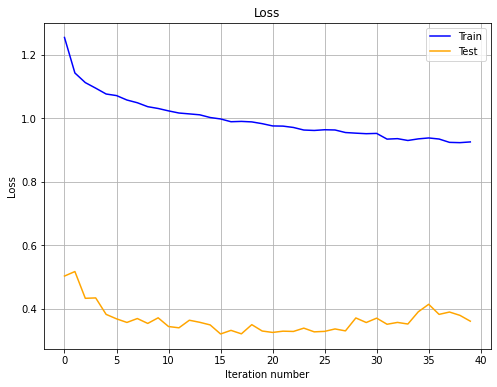

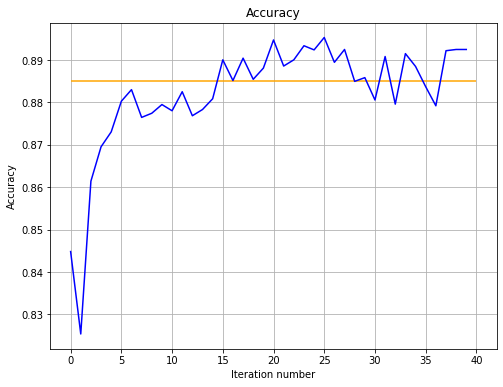

In [95]:
# Visualize
plt.figure(figsize=(8, 6))
plt.title("Loss")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.plot(train_loss_history, 'blue', label="Train")
plt.plot(test_loss_history, 'orange', label="Test")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.title("Accuracy")
plt.xlabel("Iteration number")
plt.ylabel("Accuracy")
plt.hlines(0.885, 0, len(test_acc_history), 'orange')
plt.plot(test_acc_history, 'blue')
plt.grid()
plt.show()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [0]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.Linear(100, 100),
            nn.Linear(100, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [117]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
              ReLU-3                  [-1, 300]               0
            Linear-4                  [-1, 100]          30,100
            Linear-5                  [-1, 100]          10,100
            Linear-6                   [-1, 10]           1,010
Total params: 276,710
Trainable params: 276,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.06
Estimated Total Size (MB): 1.07
----------------------------------------------------------------


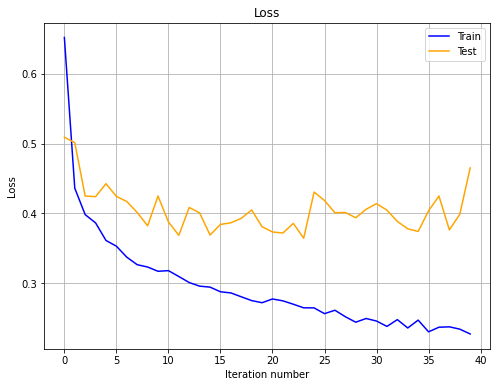

In [120]:
model = OverfittingNeuralNetwork().to(device)
train_loss_history, test_loss_history, test_acc_history = train(model, 
                                                                train_loader, 
                                                                test_loader, 
                                                                n_epoch=40)

# Visualize
plt.figure(figsize=(8, 6))
plt.title("Loss")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.plot(train_loss_history, 'blue', label="Train")
plt.plot(test_loss_history, 'orange', label="Test")
plt.legend()
plt.grid()
plt.show()

Из графика выше видно, что лосс при обучении уменьшается, а на тест-сете сначала уменьшается, а потом медленно увеличивается.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [0]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 300),
            nn.BatchNorm1d(300, eps=1e-5),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.Linear(100, 100),
            nn.Linear(100, num_classes),
            nn.Dropout(0.6),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [112]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
       BatchNorm1d-3                  [-1, 300]             600
              ReLU-4                  [-1, 300]               0
            Linear-5                  [-1, 100]          30,100
              ReLU-6                  [-1, 100]               0
            Linear-7                  [-1, 100]          10,100
            Linear-8                   [-1, 10]           1,010
           Dropout-9                   [-1, 10]               0
       LogSoftmax-10                   [-1, 10]               0
Total params: 277,310
Trainable params: 277,310
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.06
Estimated T

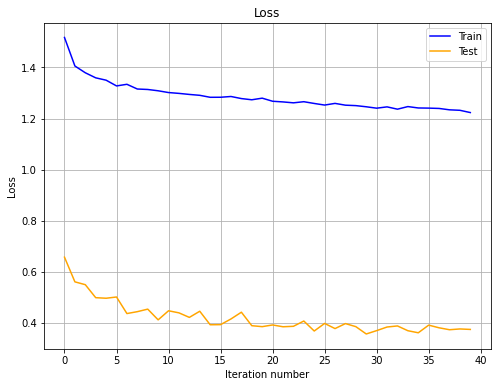

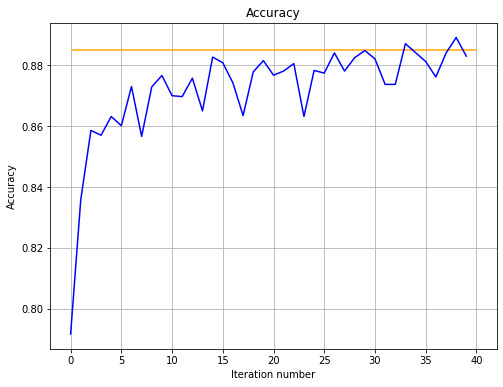

In [122]:
model = FixedNeuralNetwork().to(device)
train_loss_history, test_loss_history, test_acc_history = train(model, 
                                                                train_loader, 
                                                                test_loader, 
                                                                n_epoch=40)

# Visualize
plt.figure(figsize=(8, 6))
plt.title("Loss")
plt.xlabel("Iteration number")
plt.ylabel("Loss")
plt.plot(train_loss_history, 'blue', label="Train")
plt.plot(test_loss_history, 'orange', label="Test")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.title("Accuracy")
plt.xlabel("Iteration number")
plt.ylabel("Accuracy")
plt.hlines(0.885, 0, len(test_acc_history), 'orange')
plt.plot(test_acc_history, 'blue')
plt.grid()
plt.show()

Из графика лосса видим, что и на трейн-сете, и на тест-сете лосс уменьшается. Значит, переобучение побеждено.

### Conclusions:
Важно построить сеть правильно, чтобы не переобучиться: то есть, хорошо использовать BatchNormalization и Dropout. 
